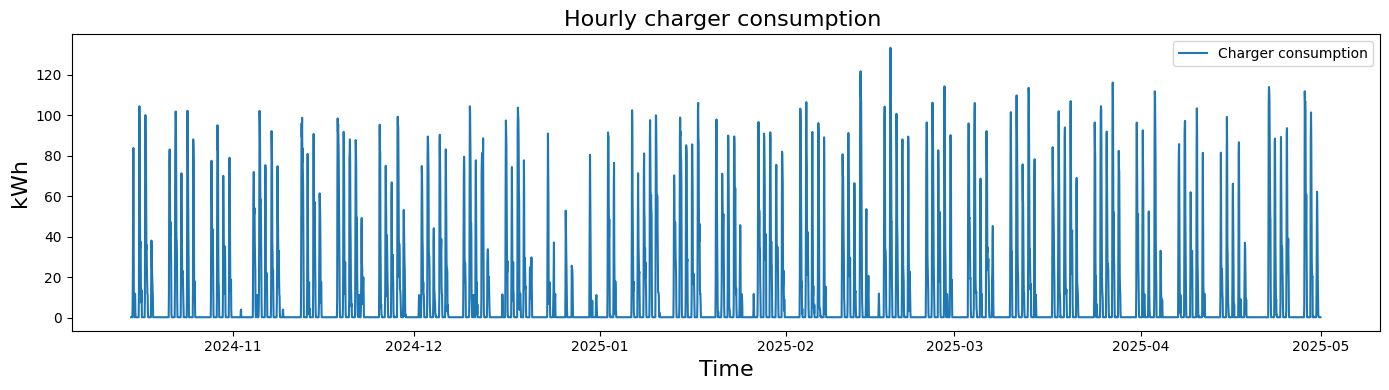

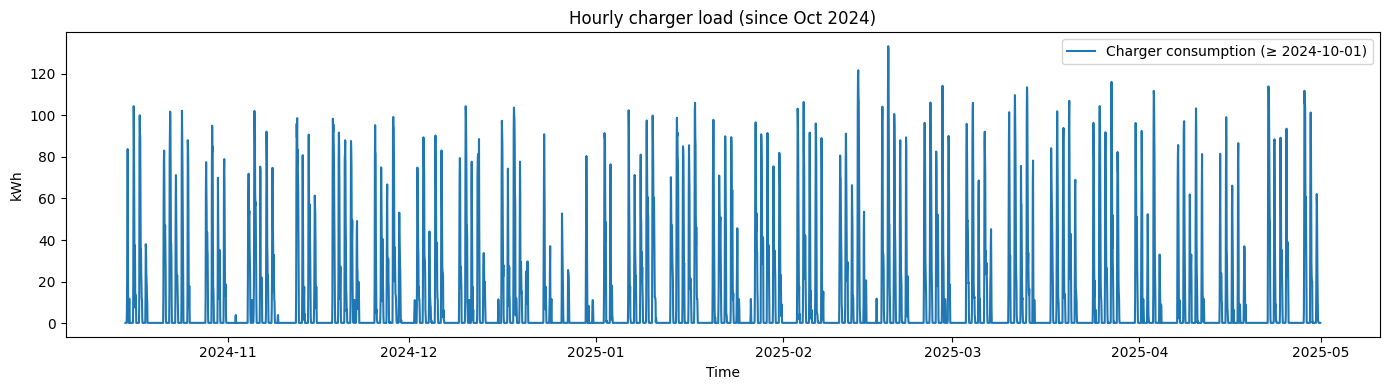

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from pandas import read_csv
from datetime import datetime
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.models import Sequential

# ----------------- load & index ---------------------------------
df = (pd.read_csv("./Charging_data_new.csv",  # adjust path
                  parse_dates=["Date"])
        .set_index("Date")
        .sort_index())
'''
df = df.asfreq("h")                      # full hourly grid
df["raw"] = df["Chargers"]               # untouched copy

# ------------- build a year-month-hour key -----------------------
key = df.index.strftime("%Y-%m-%H")      # e.g. "2024-07-15"

# mean Chargers for each (year-month, hour-of-day) bucket
ymh_mean = df.groupby(key)["raw"].transform("mean")

# ------------------ gap filling ---------------------------------
df["Chargers"] = df["raw"].fillna(ymh_mean)
assert not df["Chargers"].isna().any(), "Still have gaps!"
'''
# ------------------ PLOT ----------------------------------------
plt.figure(figsize=(14, 4))
plt.plot(df.index, df["Chargers"], label="Charger consumption")
plt.title("Hourly charger consumption ", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.ylabel("kWh", fontsize=16)
plt.tight_layout()
plt.legend()
plt.show()

# ------------------ PLOT: since 2024-10 --------------------------
cutoff = "2024-10-01"            # YYYY-MM-DD string works with DatetimeIndex
recent = df.loc[cutoff:]         # same as df[df.index >= cutoff]

plt.figure(figsize=(14, 4))
plt.plot(recent.index, recent["Chargers"],
         label=f"Charger consumption (≥ {cutoff})")
plt.title("Hourly charger load (since Oct 2024)")
plt.xlabel("Time")
plt.ylabel("kWh")
plt.tight_layout()
plt.legend()
plt.show()



C:\Users\user\AppData\Local\Temp\ipykernel_20128\2429303867.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index=pd.date_range(idx_start, periods=FORECAST_HR, freq="H")


Mean-of-100-days →  MAE =   5.77   RMSE =   8.94   R² =   0.77


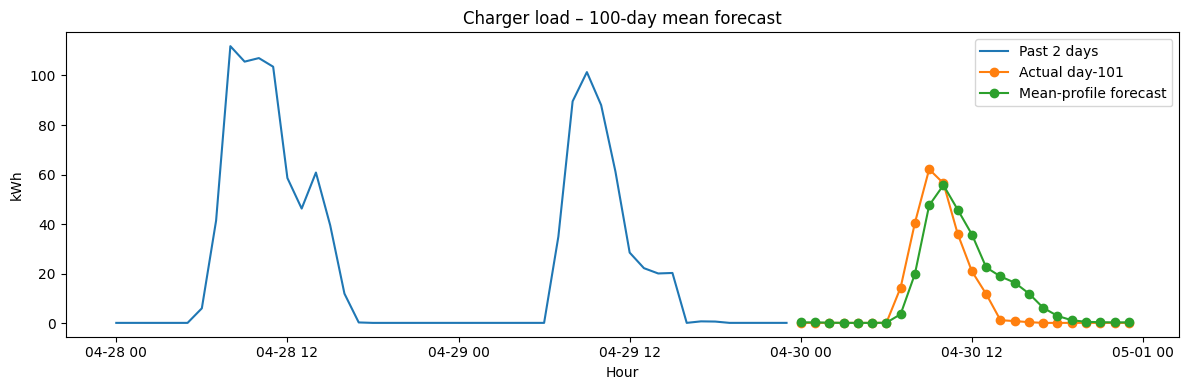

In [38]:
# ───────────────────────── IMPORTS ─────────────────────────
import math
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ───────────────────────── CONFIG ─────────────────────────
TARGET_COL    = "Chargers"
DAYS_TRAIN    = 175                 # ← 100-day training window
HRS_PER_DAY   = 24
LOOK_BACK     = DAYS_TRAIN * HRS_PER_DAY        # 100 × 24 = 2 400 h
FORECAST_HR   = 24                              # 1-day forecast
SHOW_DAYS     = 2                               # how many past days to draw

# ─────────────────────── MAIN ───────────────────────
if __name__ == "__main__":

    # -------- df must already be in memory --------
    needed_rows = LOOK_BACK + FORECAST_HR         # 2 424 rows required
    if len(df) < needed_rows:
        raise ValueError(f"Need ≥ {needed_rows} rows (got {len(df)})")
    
    # if you want to change the forecast date
    df_less = df.iloc[:]

    # keep the last 101 days (100 for training + 1 for truth/forecast)
    df_recent = df_less.iloc[-needed_rows:]

    # split 100-day history vs. day-101 truth
    df_hist = df_recent.iloc[:LOOK_BACK]          # rows 0 … 2 399
    df_real = df_recent.iloc[LOOK_BACK:]          # rows 2 400 … 2 423
    y_true  = df_real[TARGET_COL].values

    # ---------- mean-of-period forecast ----------
    hist_matrix = df_hist[TARGET_COL].values.reshape(DAYS_TRAIN, HRS_PER_DAY)
    preds = hist_matrix.mean(axis=0)              # length-24 vector

    idx_start = df_hist.index[-1] + timedelta(hours=1)
    pred_avg = pd.Series(
        preds,
        index=pd.date_range(idx_start, periods=FORECAST_HR, freq="H")
    )

    # ------------- evaluation metrics -------------
    mae  = mean_absolute_error(y_true, pred_avg.values)
    rmse = math.sqrt(mean_squared_error(y_true, pred_avg.values))
    r2   = r2_score(y_true, pred_avg.values)
    print(f"Mean-of-100-days →  MAE = {mae:6.2f}   RMSE = {rmse:6.2f}   R² = {r2:6.2f}")

    # ------------------- plot ---------------------
    past_to_show = df_hist.iloc[-SHOW_DAYS*HRS_PER_DAY:][TARGET_COL]  # last 3 × 24 rows
    actual = df_real[TARGET_COL]

    plt.figure(figsize=(12, 4))
    plt.plot(past_to_show.index, past_to_show.values,        label=f"Past {SHOW_DAYS} days")
    plt.plot(actual.index,     actual.values,  "-o",         label="Actual day-101")
    plt.plot(pred_avg.index,   pred_avg.values, "-o",        label="Mean-profile forecast")
    plt.title("Charger load – 100-day mean forecast")
    plt.xlabel("Hour")
    plt.ylabel("kWh")
    plt.legend()
    plt.tight_layout()
    plt.show()


Weekday-aware mean →  MAE =   3.45   RMSE =   6.07   R² =   0.89


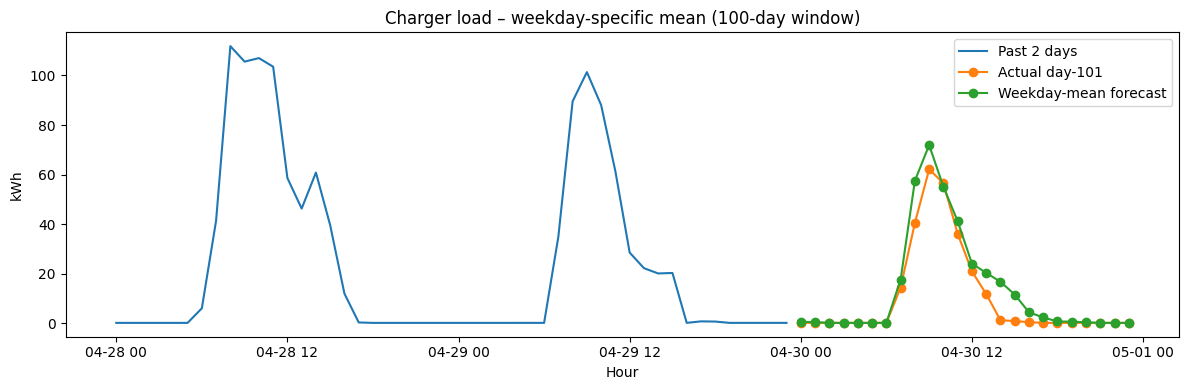

In [40]:
# ───────────────────────── IMPORTS ─────────────────────────
import math
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ───────────────────────── CONFIG ─────────────────────────
TARGET_COL  = "Chargers"
DAYS_BACK   = 175          # how far to look back
HRS_PER_DAY = 24
FORECAST_HR = 24               # 1-day forecast horizon
SHOW_DAYS   = 2              # how many past days to draw

# ─────────────────────── MAIN ───────────────────────
if __name__ == "__main__":

    # need 100 days of history + 1 day of truth
    needed_rows = DAYS_BACK * HRS_PER_DAY + FORECAST_HR
    '''
    if len(df) < needed_rows:
        raise ValueError(f"Need ≥ {needed_rows} rows (got {len(df)})")
    '''

    # if you want to change the forecast date
    df_less = df.iloc[:]

    # keep the last 101 days (100 for training + 1 for truth/forecast)
    df_recent = df_less.iloc[-needed_rows:]

    # history vs. truth
    df_hist = df_recent.iloc[: DAYS_BACK * HRS_PER_DAY]    # 100 days
    df_real = df_recent.iloc[DAYS_BACK * HRS_PER_DAY :]    # forecast target (24 h)
    y_true  = df_real[TARGET_COL].values

    # -------- weekday-specific mean profiles --------
    n_weeks      = DAYS_BACK // 7          # 14 complete weeks inside 100 days
    hours_per_wd = n_weeks * HRS_PER_DAY   # 14 × 24 = 336 samples per weekday

    profiles = {}                          # weekday → 24-vector
    for wd in range(7):                    # 0 = Mon … 6 = Sun
        sel = df_hist[df_hist.index.weekday == wd][TARGET_COL].tail(hours_per_wd)
        if len(sel) < hours_per_wd:        # not enough full weeks? skip / fallback
            continue
        # reshape: (n_weeks, 24) then average down the weeks axis
        profiles[wd] = sel.values.reshape(n_weeks, HRS_PER_DAY).mean(axis=0)

    # fallback in case a profile is missing (rare)
    overall_profile = df_hist[TARGET_COL].values.reshape(-1, HRS_PER_DAY).mean(axis=0)

    # -------- choose the profile for the day we’re forecasting --------
    next_day_start = df_hist.index[-1] + timedelta(hours=1)       # first hr to predict
    next_wd        = next_day_start.weekday()
    preds          = profiles.get(next_wd, overall_profile)       # fallback to overall

    pred_avg = pd.Series(
        preds,
        index=pd.date_range(next_day_start, periods=FORECAST_HR, freq="h")
    )

    # -------- evaluation --------
    mae  = mean_absolute_error(y_true, pred_avg.values)
    rmse = math.sqrt(mean_squared_error(y_true, pred_avg.values))
    r2   = r2_score(y_true, pred_avg.values)
    print(f"Weekday-aware mean →  MAE = {mae:6.2f}   RMSE = {rmse:6.2f}   R² = {r2:6.2f}")

    # -------- plot (last 3 days + forecast) --------
    past_to_show = df_hist.iloc[-SHOW_DAYS * HRS_PER_DAY:][TARGET_COL]
    actual       = df_real[TARGET_COL]

    plt.figure(figsize=(12, 4))
    plt.plot(past_to_show.index, past_to_show.values, label=f"Past {SHOW_DAYS} days")
    plt.plot(actual.index,      actual.values,      "-o", label="Actual day-101")
    plt.plot(pred_avg.index,    pred_avg.values,    "-o", label="Weekday-mean forecast")
    plt.title("Charger load – weekday-specific mean (100-day window)")
    plt.xlabel("Hour")
    plt.ylabel("kWh")
    plt.legend()
    plt.tight_layout()
    plt.show()


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in

AR(24) →  MAE = 4.85   RMSE = 7.72   R² = 0.83


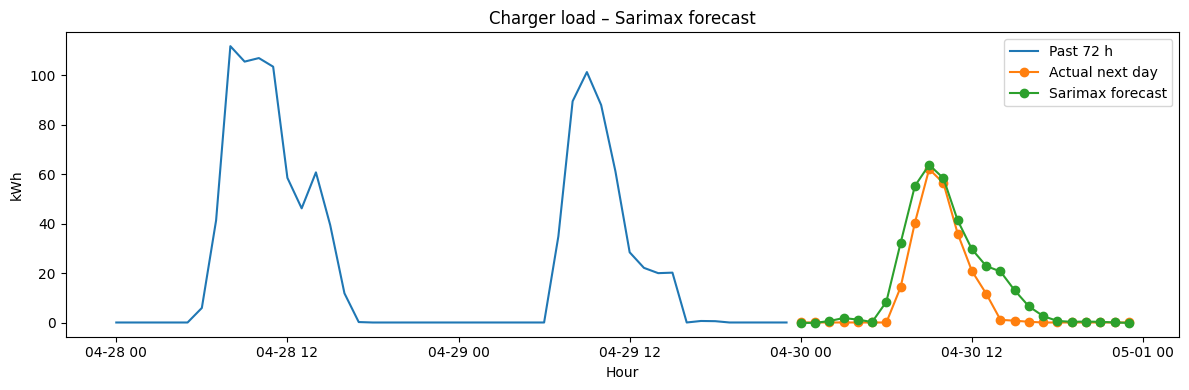

In [ ]:
# ───────────────────────── IMPORTS ─────────────────────────
import math
from pathlib import Path
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm

# ───────────────────────── CONFIG ──────────────────────────
TARGET_COL   = "Chargers"
DAYS_TRAIN   = 175    # train on last 30 days
HRS_PER_DAY  = 24
LOOK_BACK    = DAYS_TRAIN * HRS_PER_DAY  # 720
N_FORECAST   = 24      # 1-day ahead
AR_ORDER     = 24      # AR(24)
SHOW_HOURS   = 2 * HRS_PER_DAY  # 72 h

if __name__ == "__main__":

    # ---------- load & sanity-check ----------
    # assume df is already in memory, indexed by pd.DatetimeIndex
    needed = LOOK_BACK + N_FORECAST
    if len(df) < needed:
        raise ValueError(f"Need ≥ {needed} rows (got {len(df)})")

    # last 30 days for training, next 24h for test
    df_recent = df.iloc[-needed:]
    df_train  = df_recent.iloc[:LOOK_BACK]
    df_test   = df_recent.iloc[LOOK_BACK:]
    y_train   = df_train[TARGET_COL].astype(float)
    y_test    = df_test[TARGET_COL]

    # ---------- fit AR(24) ----------
    model = sm.tsa.SARIMAX(y_train, order=(AR_ORDER, 0, 0),
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    res = model.fit(disp=False)

    # ---------- 24-step forecast ----------
    preds = res.forecast(steps=N_FORECAST)

    # ── **CRUCIAL**: align the forecast’s index to your test set ──
    preds.index = df_test.index

    # ---------- evaluation ----------
    mae  = mean_absolute_error(y_test, preds)
    rmse = math.sqrt(mean_squared_error(y_test, preds))
    r2   = r2_score(y_test, preds)
    print(f"AR({AR_ORDER}) →  MAE = {mae:.2f}   RMSE = {rmse:.2f}   R² = {r2:.2f}")

    # ---------------- plot ---------------------
    hist_3d = df_train.iloc[-SHOW_HOURS:][TARGET_COL]

    plt.figure(figsize=(12, 4))
    plt.plot(hist_3d.index, hist_3d.values,      label="Past 72 h")
    plt.plot(df_test.index,   y_test.values,     "-o", label="Actual next day")
    plt.plot(preds.index,     preds.values,      "-o", label="Sarimax forecast")

    plt.title("Charger load – Sarimax forecast")
    plt.xlabel("Hour")
    plt.ylabel("kWh")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [162]:
"""
LSTM(1×32) baseline – train on the last 30 days, forecast the last 24 h
────────────────────────────────────────────────────────────────────────
• no extra calendar / holiday / EV features
• scales the 30-day window to [0,1], builds many (24→1) training pairs
• walk-forward generates a 24-step forecast
• prints MAE / RMSE / R2 vs. the real last-day values
• shows past-vs-forecast plot
"""

# ───────────────────────── IMPORTS ─────────────────────────
import math
from pathlib import Path
from datetime import timedelta
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ───────────────────────── CONFIG ──────────────────────────
TARGET_COL   = "Chargers"

DAYS_TRAIN   = 175    # train horizon
HRS_PER_DAY  = 24
LOOK_BACK    = DAYS_TRAIN * HRS_PER_DAY     # 30 × 24 = 720
N_FORECAST   = 24        # forecast 1 day ahead

SEQ_LEN      = 24       # how many lags the LSTM sees  (1 per hour)
LSTM_UNITS   = 64      # neurons in the LSTM layer
EPOCHS       = 75
BATCH_SIZE   = 16
SEED         = 42

# reproducibility
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

# ─────────────────────── MAIN ───────────────────────
if __name__ == "__main__":

    # ---------- load & sanity-check ----------
    # (assumes you already have df with a DateTimeIndex & “Chargers” col)
    needed_rows = LOOK_BACK + N_FORECAST
    if len(df) < needed_rows:
        raise ValueError(f"Need ≥ {needed_rows} rows (got {len(df)})")
    
    df_less = df.iloc[:]

    # keep only the *last* 31 days (30 for training, 1 for test)
    df_recent = df_less.iloc[-needed_rows:]

    


    df_train = df_recent.iloc[:LOOK_BACK]          # 30 days
    df_test  = df_recent.iloc[LOOK_BACK:]          # final 24 h
    y_train  = df_train[TARGET_COL].values.reshape(-1, 1)
    y_test   = df_test[TARGET_COL].values.reshape(-1, 1)

    # ---------- scaling ----------
    scaler = MinMaxScaler()
    y_train_scaled = scaler.fit_transform(y_train).flatten()

    # ---------- build (X,y) pairs ----------
    X, y = [], []
    for i in range(len(y_train_scaled) - SEQ_LEN):
        X.append(y_train_scaled[i : i + SEQ_LEN])
        y.append(y_train_scaled[i + SEQ_LEN])
    X = np.array(X).reshape(-1, SEQ_LEN, 1)   # (samples, timesteps, features)
    y = np.array(y)

    # ---------- define & fit LSTM ----------
    model = Sequential([
        LSTM(LSTM_UNITS, input_shape=(SEQ_LEN, 1)),
        Dense(1, activation="linear")
    ])
    model.compile(loss="mse", optimizer="adam")
    model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

    # ---------- 24-step walk-forward forecast ----------
    last_seq = y_train_scaled[-SEQ_LEN:].tolist()    # start-state (scaled)
    preds_scaled = []
    for _ in range(N_FORECAST):
        x_input = np.array(last_seq[-SEQ_LEN:]).reshape(1, SEQ_LEN, 1)
        next_val = model.predict(x_input, verbose=0)[0, 0]
        preds_scaled.append(next_val)
        last_seq.append(next_val)

    preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()

    # ---------- evaluation ----------
    mae  = mean_absolute_error(y_test, preds)
    rmse = math.sqrt(mean_squared_error(y_test, preds))
    r2   = r2_score(y_test, preds)
    print(f"LSTM(1×{LSTM_UNITS}) →  MAE = {mae:6.2f}   RMSE = {rmse:6.2f}   R2 = {r2:6.2f}")

    # ---------------- plot (3-day window) ----------------
    hrs_history = 2 * 24                 # 72 h
    hist_3d = df_recent.iloc[-(hrs_history + N_FORECAST):-N_FORECAST]   # last 3 days

    plt.figure(figsize=(12, 4))
    plt.plot(hist_3d.index, hist_3d[TARGET_COL], label="Past 72 h")
    plt.plot(df_test.index, y_test.flatten(), "-o", label="Actual day-31")
    plt.plot(df_test.index, preds, "-o", label="LSTM forecast")
    plt.title("Charger load – LSTM forecast")
    plt.xlabel("Hour"); plt.ylabel("kWh")
    plt.legend(); plt.tight_layout(); plt.show()



c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

C:\Users\user\AppData\Local\Temp\ipykernel_20128\2212643125.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recent["lag_24"] = df_recent[TARGET_COL].shift(24)
C:\Users\user\AppData\Local\Temp\ipykernel_20128\2212643125.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recent["weekday_avg"] = df_recent.index.dayofweek.map(dow_mean)


LightGBM (+lag24 +weekday_avg) → MAE   6.39  RMSE  10.88  R²   0.66


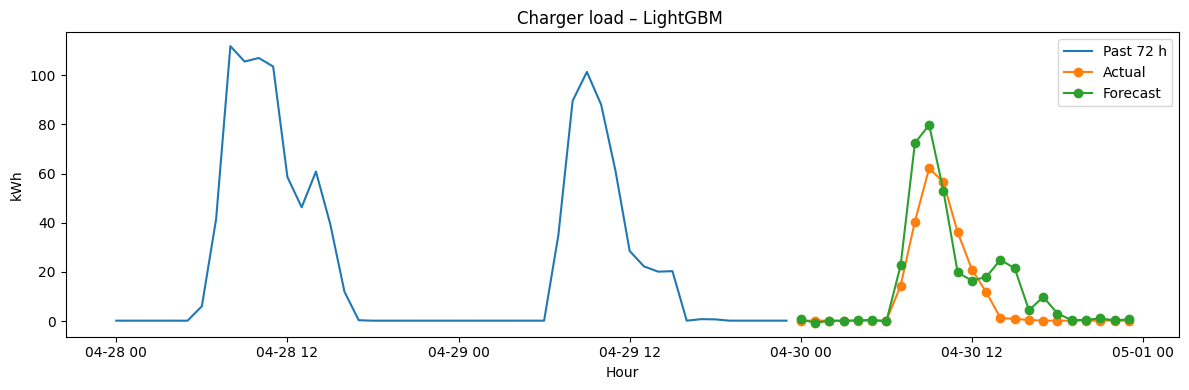

In [58]:
# ───────────── imports
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt, lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ───────────── config
TARGET_COL, DAYS_TRAIN, HRS_PER_DAY = "Chargers", 175, 24
LOOK_BACK, N_FORECAST = DAYS_TRAIN * HRS_PER_DAY, 24

LGB_PARAMS = dict(
    n_estimators      = 3000,
    learning_rate     = 0.05,
    num_leaves        = 128,
    subsample         = 0.8,
    colsample_bytree  = 0.8,
    objective         = "regression_l2",
    min_child_samples = 20,
    lambda_l1         = 0.1,
    lambda_l2         = 0.2,
    random_state      = 42,
    verbosity         = -1
)

# ───────────── helpers
def make_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    feats = pd.DataFrame(index=idx)
    feats["hour"], feats["dow"], feats["month"] = idx.hour, idx.dayofweek, idx.month
    feats["hour_sin"] = np.sin(2*np.pi*feats.hour/23);  feats["hour_cos"] = np.cos(2*np.pi*feats.hour/23)
    feats["dow_sin"]  = np.sin(2*np.pi*feats.dow/6);   feats["dow_cos"]  = np.cos(2*np.pi*feats.dow/6)
    return feats

# ───────────── main
if __name__ == "__main__":
    needed_rows = LOOK_BACK + N_FORECAST + 24          # +24 for lag feature
    if len(df) < needed_rows:
        raise ValueError(f"Need ≥ {needed_rows} rows, got {len(df)}")

    df_recent = df.iloc[-needed_rows:]
    df_recent["lag_24"] = df_recent[TARGET_COL].shift(24)

    df_train_raw = df_recent.iloc[:-N_FORECAST]
    dow_mean = df_train_raw.groupby(df_train_raw.index.dayofweek)[TARGET_COL].mean()
    df_recent["weekday_avg"] = df_recent.index.dayofweek.map(dow_mean)

    df_recent = df_recent.dropna(subset=["lag_24", "weekday_avg"])
    split_pt  = len(df_recent) - N_FORECAST
    df_train, df_test = df_recent.iloc[:split_pt], df_recent.iloc[split_pt:]

    def build(frame):
        return make_calendar_features(frame.index).join(frame[["lag_24","weekday_avg"]])

    X_train, y_train = build(df_train), df_train[TARGET_COL]
    X_test,  y_test  = build(df_test),  df_test[TARGET_COL]

    # ────────── LightGBM fit (no “verbose=” argument)
    gbm = lgb.LGBMRegressor(**LGB_PARAMS)
    gbm.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="l2",
        
        callbacks=[lgb.log_evaluation(period=0)]   # silences native logs
    )

    preds = gbm.predict(X_test)

    mae  = mean_absolute_error(y_test, preds)
    rmse = math.sqrt(mean_squared_error(y_test, preds))
    r2   = r2_score(y_test, preds)
    print(f"LightGBM (+lag24 +weekday_avg) → MAE {mae:6.2f}  RMSE {rmse:6.2f}  R² {r2:6.2f}")

    # ────────── plot
    hrs_hist = 48
    hist = df_recent.iloc[-(hrs_hist+N_FORECAST):-N_FORECAST]
    plt.figure(figsize=(12,4))
    plt.plot(hist.index, hist[TARGET_COL], label="Past 72 h")
    plt.plot(y_test.index, y_test, "-o", label="Actual")
    plt.plot(y_test.index, preds, "-o", label="Forecast")
    plt.title("Charger load – LightGBM ")
    plt.xlabel("Hour");  plt.ylabel("kWh");  plt.legend();  plt.tight_layout();  plt.show()

   


LightGBM (lag-24 only) → MAE   4.45  RMSE   6.33  R²   0.88


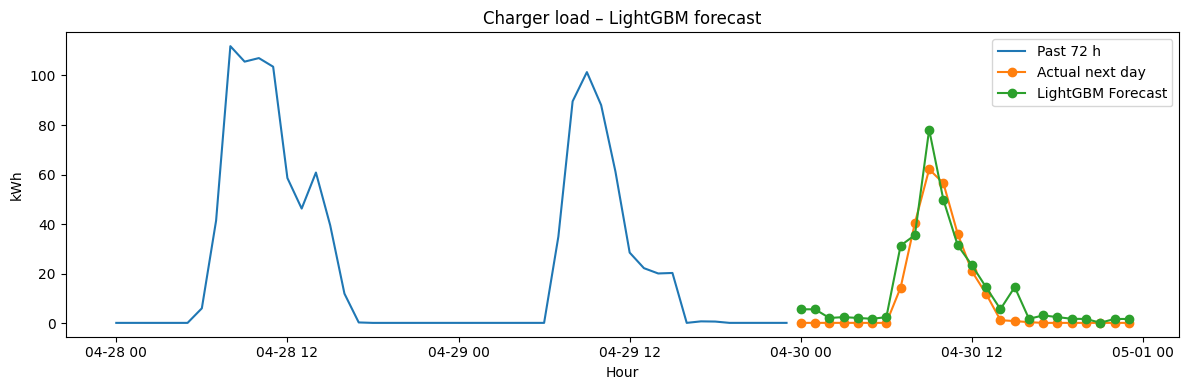

In [106]:
# ───────────── imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ───────────── config
TARGET_COL, DAYS_TRAIN, HRS_PER_DAY = "Chargers", 175 , 24
LOOK_BACK, N_FORECAST = DAYS_TRAIN * HRS_PER_DAY, 24

LGB_PARAMS = dict(
    n_estimators      = 3000,
    learning_rate     = 0.05,
    num_leaves        = 128,
    subsample         = 0.8,
    colsample_bytree  = 0.8,
    objective         = "regression_l2",
    min_child_samples = 20,
    lambda_l1         = 0.1,
    lambda_l2         = 0.2,
    random_state      = 42,
    verbosity         = -1
)

if __name__ == "__main__":

    # ---- need enough data for 24-h lag + train + test
    needed_rows = LOOK_BACK + N_FORECAST + HRS_PER_DAY
    if len(df) < needed_rows:
        raise ValueError(f"Need ≥ {needed_rows} rows, got {len(df)}")
    
    df_less = df.iloc[:]

    # ---- take the last block, then build only the 24-h lag
    df_recent = df_less.iloc[-needed_rows:].copy()
    df_recent["lag_24"] = df_recent[TARGET_COL].shift(HRS_PER_DAY)
    df_recent["day_of_week"] = df_recent.index.dayofweek

    

    # ---- calculate weekday average ----
    weekday_avg = df_recent.groupby('day_of_week')[TARGET_COL].transform('mean')
    df_recent["weekday_avg"] = weekday_avg

    # drop the first 24h (where lag is NaN)
    df_recent = df_recent.dropna(subset=["lag_24"])

    # split into train vs. test
    split_pt     = len(df_recent) - N_FORECAST
    df_train     = df_recent.iloc[:split_pt]
    df_test      = df_recent.iloc[split_pt:]
    X_train, y_train = df_train[["lag_24"]], df_train[TARGET_COL]
    X_test,  y_test  = df_test[ ["lag_24"]], df_test[ TARGET_COL]

    # ---- fit LightGBM on the single lag feature ----
    gbm = lgb.LGBMRegressor(**LGB_PARAMS)
    gbm.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="l2",
        callbacks=[lgb.log_evaluation(period=0)]
    )

    # ---- predict and evaluate ----
    preds = gbm.predict(X_test)
    mae  = mean_absolute_error(y_test, preds)
    rmse = math.sqrt(mean_squared_error(y_test, preds))
    r2   = r2_score(y_test, preds)
    print(f"LightGBM (lag-24 only) → MAE {mae:6.2f}  RMSE {rmse:6.2f}  R² {r2:6.2f}")

    # ---- plot last 72h history + 24h forecast ----
    hrs_hist = 2 * HRS_PER_DAY
    hist     = df_recent.iloc[-(hrs_hist + N_FORECAST):-N_FORECAST][TARGET_COL]

    plt.figure(figsize=(12,4))
    plt.plot(hist.index,     hist,    label="Past 72 h")
    plt.plot(y_test.index,   y_test,  "-o", label="Actual next day")
    plt.plot(y_test.index,   preds,   "-o", label="LightGBM Forecast")
    plt.title("Charger load – LightGBM forecast")
    plt.xlabel("Hour"); plt.ylabel("kWh")
    plt.legend(); plt.tight_layout(); plt.show()


CatBoost (lag-24 + weekday) → MAE   7.75  RMSE  13.19  R²   0.83


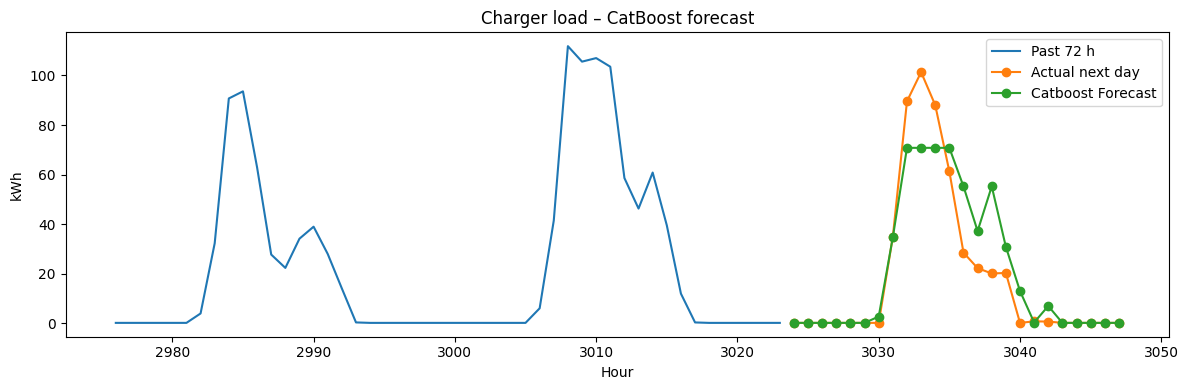

In [ ]:
# ───────────── imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ───────────── config
TARGET_COL, DAYS_TRAIN, HRS_PER_DAY = "Chargers", 175, 24
LOOK_BACK, N_FORECAST = DAYS_TRAIN * HRS_PER_DAY, 24

CATBOOST_PARAMS = dict(
    iterations        = 3000,
    learning_rate     = 0.05,
    depth             = 6,
    subsample         = 0.8,
    colsample_bylevel = 0.8,
    loss_function     = "MAE",
    l2_leaf_reg       = 3,
    random_seed       = 42,
    verbose           = False
)

if __name__ == "__main__":

    # ---- check required rows ----
    needed_rows = LOOK_BACK + N_FORECAST + HRS_PER_DAY
    if len(df) < needed_rows:
        raise ValueError(f"Need ≥ {needed_rows} rows, got {len(df)}")

    df_less = df.iloc[:]

    # ---- last block & lag ----
    df_recent = df_less.iloc[-needed_rows:].copy()
    df_recent["lag_24"] = df_recent[TARGET_COL].shift(HRS_PER_DAY)
    df_recent["day_of_week"] = df_recent.index.dayofweek

    

    # ---- calculate weekday average ----
    weekday_avg = df_recent.groupby('day_of_week')[TARGET_COL].transform('mean')
    df_recent["weekday_avg"] = weekday_avg

    # ---- remove weekends ----
    df_recent = df_recent[df_recent["day_of_week"] < 5].reset_index(drop=True)
    

    df_recent = df_recent.dropna(subset=["lag_24"])

    # ---- split train/test ----
    split_pt = len(df_recent) - N_FORECAST
    df_train = df_recent.iloc[:split_pt]
    df_test = df_recent.iloc[split_pt:]
    X_train, y_train = df_train[["lag_24", "day_of_week"]], df_train[TARGET_COL]
    X_test, y_test = df_test[["lag_24", "day_of_week"]], df_test[TARGET_COL]

    # ---- fit CatBoost ----
    cbr = CatBoostRegressor(**CATBOOST_PARAMS)
    cbr.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

    # ---- predict and evaluate ----
    preds = cbr.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = math.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"CatBoost (lag-24 + weekday) → MAE {mae:6.2f}  RMSE {rmse:6.2f}  R² {r2:6.2f}")

    # ---- plot ----
    hrs_hist = 2 * HRS_PER_DAY
    hist = df_recent.iloc[-(hrs_hist + N_FORECAST):-N_FORECAST][TARGET_COL]

    plt.figure(figsize=(12, 4))
    plt.plot(hist.index, hist, label="Past 72 h")
    plt.plot(y_test.index, y_test, "-o", label="Actual next day")
    plt.plot(y_test.index, preds, "-o", label="Catboost Forecast")
    plt.title("Charger load – CatBoost forecast")
    plt.xlabel("Hour")
    plt.ylabel("kWh")
    plt.legend()
    plt.tight_layout()
    plt.show()


[0]	validation_0-mae:9.63907
[1]	validation_0-mae:9.14869
[2]	validation_0-mae:9.14870
[3]	validation_0-mae:9.14871
[4]	validation_0-mae:8.58589
[5]	validation_0-mae:8.03835
[6]	validation_0-mae:7.55270
[7]	validation_0-mae:7.14342
[8]	validation_0-mae:7.14343
[9]	validation_0-mae:7.14345
[10]	validation_0-mae:6.67594
[11]	validation_0-mae:6.35039
[12]	validation_0-mae:5.99841
[13]	validation_0-mae:5.58989
[14]	validation_0-mae:5.58989
[15]	validation_0-mae:5.32745
[16]	validation_0-mae:5.32746
[17]	validation_0-mae:4.98058
[18]	validation_0-mae:4.71042
[19]	validation_0-mae:4.44937
[20]	validation_0-mae:4.23213
[21]	validation_0-mae:4.00730
[22]	validation_0-mae:3.79261
[23]	validation_0-mae:3.68776
[24]	validation_0-mae:3.68777
[25]	validation_0-mae:3.58058
[26]	validation_0-mae:3.44783
[27]	validation_0-mae:3.44784
[28]	validation_0-mae:3.32710
[29]	validation_0-mae:3.22261
[30]	validation_0-mae:3.16858
[31]	validation_0-mae:3.16858
[32]	validation_0-mae:3.16858
[33]	validation_0-ma

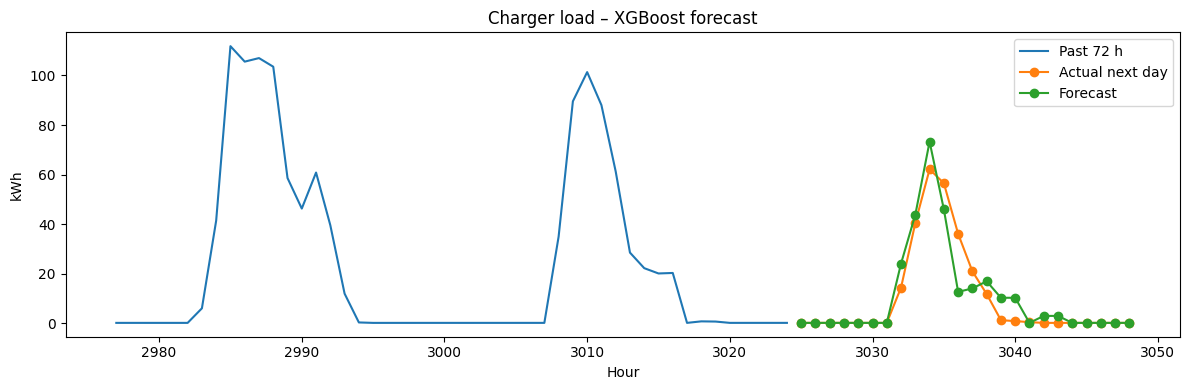

In [157]:
# ───────────── imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ───────────── config
TARGET_COL, DAYS_TRAIN, HRS_PER_DAY = "Chargers", 175, 24
LOOK_BACK, N_FORECAST = DAYS_TRAIN * HRS_PER_DAY, 24

XGB_PARAMS = dict(
    n_estimators      = 3000,
    learning_rate     = 0.05,
    max_depth         = 6,
    subsample         = 0.8,
    colsample_bytree  = 0.8,
    objective         = "reg:absoluteerror",
    reg_lambda        = 3,
    random_state      = 42,
    verbosity         = 0
)

if __name__ == "__main__":

    # ---- check required rows ----
    needed_rows = LOOK_BACK + N_FORECAST + HRS_PER_DAY
    if len(df) < needed_rows:
        raise ValueError(f"Need ≥ {needed_rows} rows, got {len(df)}")

    df_less = df.iloc[:]

    # ---- last block & lag ----
    df_recent = df_less.iloc[-needed_rows:].copy()
    df_recent["lag_24"] = df_recent[TARGET_COL].shift(HRS_PER_DAY)
    df_recent["day_of_week"] = df_recent.index.dayofweek

    # ---- calculate weekday average ----
    weekday_avg = df_recent.groupby('day_of_week')[TARGET_COL].transform('mean')
    df_recent["weekday_avg"] = weekday_avg

    # ---- remove weekends ----
    df_recent = df_recent[df_recent["day_of_week"] < 5].reset_index(drop=True)

    df_recent = df_recent.dropna(subset=["lag_24"])

    # ---- split train/test ----
    split_pt = len(df_recent) - N_FORECAST
    df_train = df_recent.iloc[:split_pt]
    df_test = df_recent.iloc[split_pt:]
    X_train, y_train = df_train[["lag_24", "day_of_week", "weekday_avg"]], df_train[TARGET_COL]
    X_test, y_test = df_test[["lag_24", "day_of_week", "weekday_avg"]], df_test[TARGET_COL]

    # ---- fit XGBoost ----
    xgbr = xgb.XGBRegressor(**XGB_PARAMS)
    xgbr.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    # ---- predict and evaluate ----
    preds = xgbr.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = math.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"XGBoost (lag-24 + weekday + weekday_avg) → MAE {mae:6.2f}  RMSE {rmse:6.2f}  R² {r2:6.2f}")

    # ---- plot ----
    hrs_hist = 2 * HRS_PER_DAY
    hist = df_recent.iloc[-(hrs_hist + N_FORECAST):-N_FORECAST][TARGET_COL]

    plt.figure(figsize=(12, 4))
    plt.plot(hist.index, hist, label="Past 72 h")
    plt.plot(y_test.index, y_test, "-o", label="Actual next day")
    plt.plot(y_test.index, preds, "-o", label="Forecast")
    plt.title("Charger load – XGBoost forecast")
    plt.xlabel("Hour")
    plt.ylabel("kWh")
    plt.legend()
    plt.tight_layout()
    plt.show()


12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Prophet → MAE   2.25  RMSE   3.71  R²   0.96


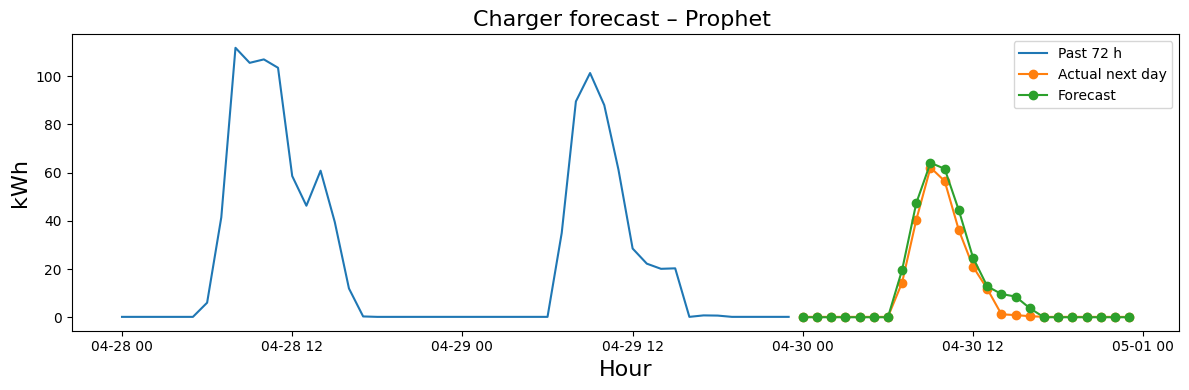

In [8]:
# ───────────── imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ───────────── config
TARGET_COL, DAYS_TRAIN, HRS_PER_DAY = "Chargers", 175, 24
LOOK_BACK, N_FORECAST = DAYS_TRAIN * HRS_PER_DAY, 24

if __name__ == "__main__":

    df_less = df.iloc[:]

    # ---- ensure proper Prophet dataframe ----
    df_recent = df_less.iloc[-(LOOK_BACK + N_FORECAST):].copy().reset_index()
    df_recent.rename(columns={df_recent.columns[0]: 'ds', TARGET_COL: 'y'}, inplace=True)

    # Ensure 'ds' is datetime type explicitly
    df_recent['ds'] = pd.to_datetime(df_recent['ds'])

    # ---- remove weekends ----
    df_recent = df_recent[df_recent['ds'].dt.dayofweek < 5].reset_index(drop=True)

    # ---- split train/test ----
    df_train = df_recent.iloc[:-N_FORECAST]
    df_test = df_recent.iloc[-N_FORECAST:]

    # ---- fit Prophet ----
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        changepoint_prior_scale=0.05
    )
    model.add_seasonality(name='hourly', period=24, fourier_order=12)

    model.fit(df_train[['ds', 'y']])

    # ---- create forecast dataframe ----
    future = model.make_future_dataframe(periods=N_FORECAST*2, freq='H')
    future = future[future['ds'].dt.dayofweek < 5].reset_index(drop=True)
    future = future.iloc[:len(df_train) + N_FORECAST]

    forecast = model.predict(future)
    preds = forecast.iloc[-N_FORECAST:]['yhat'].clip(lower=0).values

    # ---- evaluate predictions ----
    mae = mean_absolute_error(df_test['y'], preds)
    rmse = math.sqrt(mean_squared_error(df_test['y'], preds))
    r2 = r2_score(df_test['y'], preds)
    print(f"Prophet → MAE {mae:6.2f}  RMSE {rmse:6.2f}  R² {r2:6.2f}")

    # ---- plot without weekends ----
    plt.figure(figsize=(12, 4))

    recent_history = df_train[df_train['ds'].dt.dayofweek < 5].iloc[-(2*HRS_PER_DAY):]

    plt.plot(recent_history['ds'], recent_history['y'], label="Past 72 h")
    plt.plot(df_test['ds'], df_test['y'], "-o", label="Actual next day")
    plt.plot(df_test['ds'], preds, "-o", label="Forecast")

    plt.title("Charger forecast – Prophet ", fontsize=16)
    plt.xlabel("Hour", fontsize=16)
    plt.ylabel("kWh", fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.show()
